In [46]:
import os
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from IPython.display import Markdown, display

In [47]:
def load_embeddings(subject):
    path = '../embeddings/embeddings_' + subject
    normal_embs = np.load(path + '_normal.npy')
    sleepy_embs = np.load(path + '_sleepy.npy')

    return normal_embs, sleepy_embs

In [48]:
# Extracts average embedding in a segment from given embeddigs
def embeddings_segment(embeddings, video_len, segment_len):
    # The amount of frames at the end that are not taken into account
    rest = video_len % segment_len
    num_frames = video_len - rest
    avg_embeddings = []
    acum_embeddings = np.zeros(2048)
    # a blink is counted to a segment,when the blink starts in that segment
    for frame in range(num_frames + 1):
        # if frame % 1000 == 0:
        #     print(frame)
        acum_embeddings = acum_embeddings + np.array(embeddings[frame])
        # only happens at the end of a segment
        if frame % segment_len == 0 and frame != 0:
            avg_embeddings.append(acum_embeddings / segment_len)
            acum_embeddings = np.zeros(2048)
            #print('New segment: ', frame)
    normalized_embeddings = preprocessing.normalize(avg_embeddings, norm='l2')
    return normalized_embeddings

In [49]:
subject = 'sub4'
norm_embs, sleep_embs = load_embeddings(subject)

print(len(norm_embs), len(sleep_embs))
avg_norm_embs = embeddings_segment(norm_embs, len(norm_embs), 46 * 60)
avg_sleep_embs = embeddings_segment(sleep_embs, len(sleep_embs), 46 * 60)

94186 96161


In [50]:
norm_len = len(avg_norm_embs)
sleep_len = len(avg_sleep_embs)
all_embs = list(avg_norm_embs) + list(avg_sleep_embs)

print(norm_len, sleep_len)

34 34


In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pri_comps = pca.fit_transform(all_embs)
var = pca.explained_variance_ratio_
print('Percentage of variance explained by the two components: ', float(sum(var)))
pc_normal = pri_comps[:norm_len]
pc_sleep = pri_comps[norm_len:]

Percentage of variance explained by the two components:  0.6341536582022254


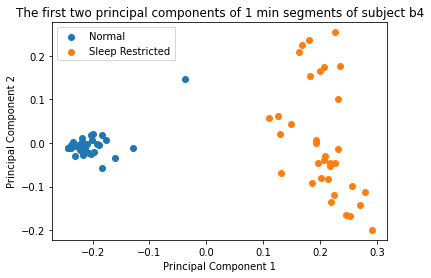

In [52]:
plt.scatter(pc_normal[:,0], pc_normal[:,1], label = 'Normal')
plt.scatter(pc_sleep[:,0], pc_sleep[:,1], label = 'Sleep Restricted')
#plt.scatter(pri_comps[:,0], pri_comps[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('The first two principal components of 1 min segments of subject '+ subject[-2:])
plt.legend()
plt.savefig('../final_figures/pc_plot_subject'+ subject[-1] + '.jpg')
plt.show()

## Check PCA Var across all subjects

In [29]:
def pca_var_check(subjects):
    sum_var = 0
    for sub in subjects:
        subject = 'sub' + str(sub)
        norm_embs, sleep_embs = load_embeddings(subject)
        avg_norm_embs = embeddings_segment(norm_embs, len(norm_embs), 46 * 60)
        avg_sleep_embs = embeddings_segment(sleep_embs, len(sleep_embs), 46 * 60)
        all_embs = list(avg_norm_embs) + list(avg_sleep_embs)
        pca = PCA(n_components=2)
        pri_comps = pca.fit_transform(all_embs)
        var = pca.explained_variance_ratio_
        sum_var += sum(var)
    return sum_var / len(subjects)
 
print(avg_var)    
subjects = [1,3,9,10,11,12,14,15,16,20,22,23,24,25]
avg_var = pca_var_check(subjects)
print("Average percentage of captured variance across all subjects: ", int(avg_var * 100))

0.6773623039162635
Average percentage of captured variance across all subjects:  67


## Classification

In [53]:
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def train_model(X_normal, X_sleepy):
    y_normal = list(np.zeros(len(X_normal)))
    y_sleepy = list(np.ones(len(X_sleepy)))

    X = X_normal + X_sleepy
    y = y_normal + y_sleepy

    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    #print("Maximum values :", scaler.data_max_)
    #print("Minimum values :", scaler.data_min_)

    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3,random_state=41)
    
    # train model
    model = SVC(kernel='linear')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_round =  round(f1, 2) 
    print("F1 score: ", f1_round)


    return model, f1_round, X_train, X_test, y_train, y_test


X_normal = list(zip(pc_normal[:,0], pc_normal[:,1]))
X_sleepy = list(zip(pc_sleep[:,0], pc_sleep[:,1]))

model, f1_round, X_train, X_test, y_train, y_test = train_model(X_normal, X_sleepy)

F1 score:  1.0


## Temporal analysis

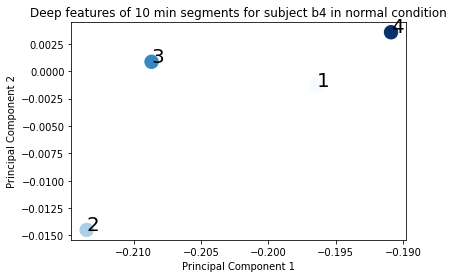

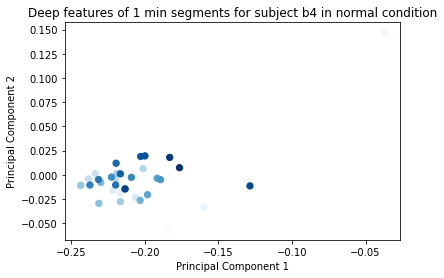

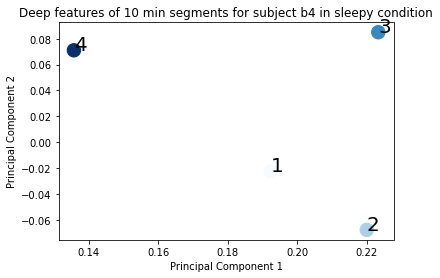

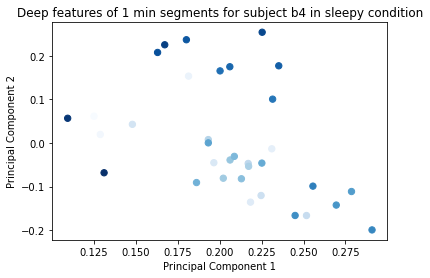

In [54]:
def gradient_plot(comp1, comp2, condition, time, size=40, text = False):
    plt.title("Deep features of " + time + " min segments for subject " + subject[-2:] + ' in ' + condition + ' condition')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.scatter(comp1, comp2, label = condition, cmap = 'Blues', c = range(len(comp1)), s=size)
    if text:
        for i in range(len(comp1)):
            plt.annotate(i + 1, (comp1[i], comp2[i]), fontsize = 20)

    plt.savefig('../final_figures/deep_gradient_scatter_' + subject + condition + time + '_min.jpg')
    plt.show()

def average(values, avg_len):
    new_values = []
    sum_values = []
    for i, val in enumerate(values):
        sum_values.append(val)
        if i % avg_len == 0 and i > 0:
            new_values.append(sum(sum_values) / len(sum_values))
            sum_values = []
            
    # if there are rest values
    if len(sum_values) > 0:
        new_values.append(sum(sum_values) / len(sum_values))
    return new_values

avg_len = 10
avg_comp1_normal = average(pc_normal[:,0], avg_len)
avg_comp2_normal = average(pc_normal[:,1], avg_len)

gradient_plot(avg_comp1_normal, avg_comp2_normal, 'normal', str(avg_len), size=180, text = True)
gradient_plot(pc_normal[:,0], pc_normal[:,1], 'normal', '1')
plt.show()

avg_comp1_sleepy = average(pc_sleep[:,0], avg_len)
avg_comp2_sleepy = average(pc_sleep[:,1], avg_len)

gradient_plot(avg_comp1_sleepy, avg_comp2_sleepy, 'sleepy', str(avg_len), size=180, text = True)
gradient_plot(pc_sleep[:,0], pc_sleep[:,1], 'sleepy', '1')
plt.show()

## Clustering techniques
### DBSCAN

[0 1 1 1 1 1 1 1 1 1 2]


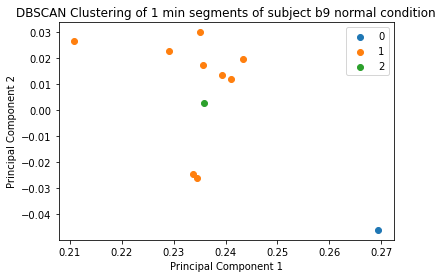

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


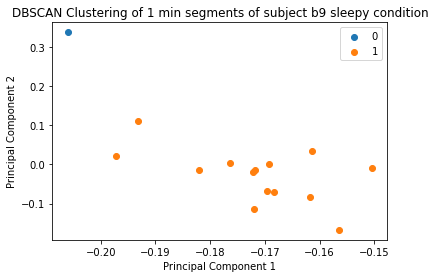

In [44]:
def plot_clusters(embs, pri_comps, epsilon, cond):
    cluster_model = DBSCAN(eps = epsilon, min_samples = 1).fit(np.array(embs))
    labels = cluster_model.labels_
    uni_labels = np.unique(labels)
    print(labels)

    all_values = []
    for label in uni_labels:
        label_values = []
        for i, emb in enumerate(pri_comps):
            if labels[i] == label:
                label_values.append(list(pri_comps[i]))
        plt.scatter(np.array(label_values)[:,0], np.array(label_values)[:,1], label = str(label))

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('DBSCAN Clustering of 1 min segments of subject ' + subject[-2:]  + ' ' + cond + ' condition')
    plt.legend()

    plt.savefig('../final_figures/clusters_' + subject + '_' + cond + '.jpg')
    plt.show()
    
    return labels

#all_labels = plot_clusters(all_embs, pri_comps, 0.3, "all")
normal_labels = plot_clusters(avg_norm_embs, pc_normal, 0.10, "normal")
sleep_labels = plot_clusters(avg_sleep_embs, pc_sleep, 0.22, "sleepy")

### Evolution of clusters trough time

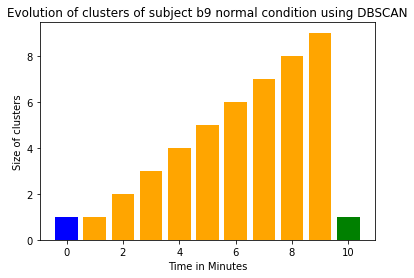

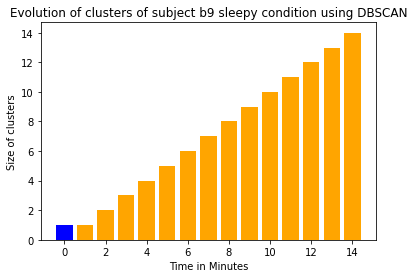

In [45]:
def make_barplot(labels, cond):
    occurences = {}
    y_values = []
    
    all_colors = ['blue', 'orange', 'green', 'red', 'cyan', 'yellow', 'purple', 'olive', 'pink']
    colors = []
    
    for lab in labels:
        if lab in occurences:
            occurences[lab] += 1
        else:
            occurences[lab] = 1
        y_values.append(occurences[lab])
        colors.append(all_colors[lab])
    x_values = range(len(labels))
    
    plt.bar(x_values, y_values, color=colors)
    plt.title("Evolution of clusters of subject " + subject[-2:] + " " + cond + " condition using DBSCAN")
    plt.xlabel("Time in Minutes")
    plt.ylabel("Size of clusters")
    plt.savefig("../final_figures/clusters_evolution_" + subject + "_" + cond + ".jpg")
    plt.show()

#make_barplot(all_labels, "all")
make_barplot(normal_labels, "normal")
make_barplot(sleep_labels, "sleepy")

In [288]:
from sklearn.manifold import TSNE
tsne_data = TSNE(perplexity = 20 ).fit_transform(np.array(all_embs))

tsne_normal = tsne_data[:norm_len]
tsne_sleep = tsne_data[norm_len:]
print(len(tsne_normal))

59


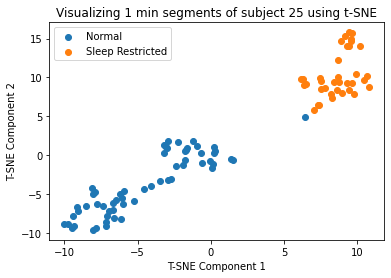

In [289]:
plt.scatter(tsne_normal[:,0], tsne_normal[:,1], label = 'Normal')
plt.scatter(tsne_sleep[:,0], tsne_sleep[:,1], label = 'Sleep Restricted')

plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.title('Visualizing 1 min segments of subject ' + subject[-2:] + ' using t-SNE')
plt.legend()
plt.savefig('../final_figures/tsne_plot_subject' + subject[-2:] + '.jpg')
plt.show()

[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


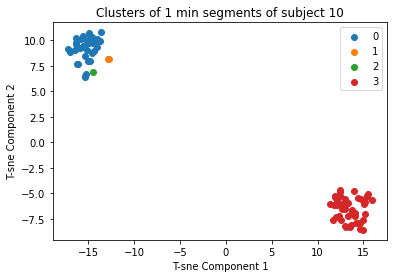

In [105]:
cluster_model = DBSCAN(eps = 0.28, min_samples = 1).fit(np.array(all_embs))
labels = cluster_model.labels_
uni_labels = np.unique(labels)
print(labels)

all_values = []
for label in uni_labels:
    label_values = []
    for i, emb in enumerate(tsne_data):
        if labels[i] == label:
            label_values.append(list(tsne_data[i]))
    plt.scatter(np.array(label_values)[:,0], np.array(label_values)[:,1], label = str(label))

plt.xlabel('T-sne Component 1')
plt.ylabel('T-sne Component 2')
plt.title('Clusters of 1 min segments of subject 10')
plt.legend()

plt.savefig('../figures/clusters_sub10_tsne.jpg')
plt.show()

## Multiple subjects analysis

In [20]:
norm_embs10, sleep_embs10 = load_embeddings('sub10')
norm_embs9, sleep_embs9 = load_embeddings('sub9')

avg_norm_embs10 = embeddings_segment(norm_embs10, len(norm_embs10), 46 * 60)
avg_sleep_embs10 = embeddings_segment(sleep_embs10, len(sleep_embs10), 46 * 60)

avg_norm_embs9 = embeddings_segment(norm_embs9, len(norm_embs9), 46 * 60)
avg_sleep_embs9 = embeddings_segment(sleep_embs9, len(sleep_embs9), 46 * 60)

print(len(norm_embs), len(sleep_embs))

all_embs = avg_norm_embs9 + avg_sleep_embs9 + avg_norm_embs10 + avg_sleep_embs10
norm_len9 = len(avg_norm_embs9)
sleep_len9 = norm_len9 + len(avg_sleep_embs9)
norm_len10 = sleep_len9 + len(avg_norm_embs10)
sleep_len10 = norm_len10 + len(avg_sleep_embs10)
print(len(all_embs))
print(sleep_len10)

pca = PCA(n_components=2)
pri_comps_multi = pca.fit_transform(all_embs)

pc_normal9 = pri_comps_multi[:norm_len9]
pc_sleep9 = pri_comps_multi[norm_len9: sleep_len9]
pc_normal10 = pri_comps_multi[sleep_len9:norm_len10]
pc_sleep10 = pri_comps_multi[norm_len10:]

print(len(pc_normal9) + len(pc_sleep9) + len(pc_normal10) + len(pc_sleep10))

114829 131558
114
114
114


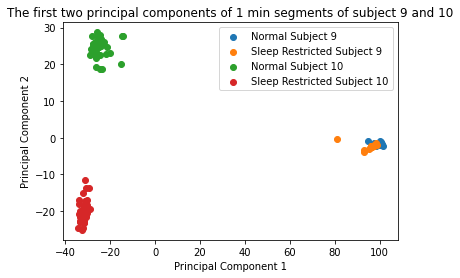

In [21]:
plt.scatter(pc_normal9[:,0], pc_normal9[:,1], label = 'Normal Subject 9')
plt.scatter(pc_sleep9[:,0], pc_sleep9[:,1], label = 'Sleep Restricted Subject 9')
plt.scatter(pc_normal10[:,0], pc_normal10[:,1], label = 'Normal Subject 10')
plt.scatter(pc_sleep10[:,0], pc_sleep10[:,1], label = 'Sleep Restricted Subject 10')
#plt.scatter(pri_comps[:,0], pri_comps[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('The first two principal components of 1 min segments of subject 9 and 10')
plt.legend()
plt.savefig('pc_plot_subj9&10.jpg')
plt.show()

### Textfile

In [ ]:
import os

def make_textfile(embeddings):
    with open('../textfiles/' + subject + '/' + subject + '_1', 'w') as f:
        for row in embeddings:
            first = True
            for value in row:
                if not first:
                    f.write(';')
                else:
                    first = False
                f.write(str(value))
            f.write('\n')
    print('done')
make_textfile(np.array(avg_norm_embs))
print(np.array(avg_norm_embs).shape)